# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
n_samples = 1000
n_features = 100
seed = 1

In [3]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, random_state=seed, noise=1.0, effective_rank=100)

Split the dataset into train and test

In [4]:
from sklearn.cross_validation import ShuffleSplit

In [5]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    pass

In [6]:
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

## SciKit-Learn SGD

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
n_iter = 10000

In [9]:
sgd = SGDRegressor(n_iter=n_iter)

In [10]:
%time sgd.fit(X_train, y_train)

CPU times: user 3.32 s, sys: 12.6 ms, total: 3.33 s
Wall time: 3.34 s


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=10000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [11]:
sgd.score(X_test, y_test)

0.82053073966698598

In [12]:
scores = []
sgd = SGDRegressor(n_iter=1, warm_start=True)
for i in range(n_iter):
    sgd.fit(X_train, y_train)
    scores += [sgd.score(X_test, y_test)]

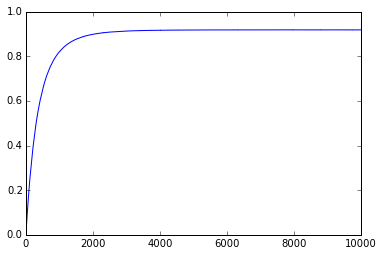

In [13]:
plt.plot(range(len(scores)), scores)

##  Parallel SGD
**Work in progress.**  
This part of the notebook has not been parallelized yet.  

### Hacky paralleld SGD

In [14]:
from multiprocessing import Pool

In [15]:
import numpy as np

In [16]:
def psgd_method(args):
    X_train, y_train, n_iter = args
    sgd = SGDRegressor(n_iter=n_iter)
    sgd.fit(X_train, y_train)
    return sgd.coef_, sgd.intercept_

In [17]:
def add_results(x, y):
    return x[0]+y[0], x[1]+y[1]

In [33]:
def parallel_sgd(sgd, pool, X, y, n_iter, n_jobs):
    
    # Split data into n_jobs chunks
    print "Spliting data..."
    data = zip(np.split(X_train, n_jobs), 
               np.split(y_train, n_jobs), 
               [n_iter for _ in range(n_jobs)])
    
    # Execute in parallel
    print "Executing in parallel..."
    result = pool.map(psgd_method, data)
    
    # Combine results
    print "Combining results..."
#     result = reduce(add_results, result)
#     result = [x/n_jobs for x in result]
    result = np.mean(np.array(result), axis=0)
    
    # Add coefs and intercept to the sgd object
    coef, intercept = result
    sgd.coef_ = coef
    sgd.intercept_ = intercept
    
    return sgd
    

In [19]:
def parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs):
    
    # Split data into n_jobs chunks
    print "Spliting data..."
    data = zip(np.split(X_train, n_jobs), 
               np.split(y_train, n_jobs))
    
    # Execute in parallel
    print "Executing %d jobs" % n_jobs
    
    scores = []
    
    sgds =[]
    for n in range(n_jobs):
        sgds += [SGDRegressor(n_iter=1, warm_start=True)]

    for i in range(n_iter):
        iter_scores = []
        iter_coefs = []
        iter_intercepts = []
        
        for n, sgd in enumerate(sgds):
            sgd.fit(data[n][0], data[n][1])
            iter_scores += [sgd.score(X_test, y_test)]
            iter_coefs += [sgd.coef_]
            iter_intercepts += [sgd.intercept_]
        
        iter_coefs = np.mean(np.array(iter_coefs), axis=0)
        iter_intercepts = np.mean(np.array(iter_intercepts), axis=0)
        
        sgd = SGDRegressor()
        sgd.coef_ = iter_coefs
        sgd.intercept_ = iter_intercepts
        iter_scores += [sgd.score(X_test, y_test)]
        
        scores += [iter_scores]
        
    return scores

In [20]:
n_jobs = 4

In [21]:
pool = Pool(processes=n_jobs)

In [41]:
%time sgd_p = parallel_sgd(SGDRegressor(), pool, X_train, y_train, n_iter/n_jobs, n_jobs)

Spliting data...
Executing in parallel...
Combining results...
CPU times: user 4.45 ms, sys: 8.93 ms, total: 13.4 ms
Wall time: 422 ms


In [42]:
sgd_p.score(X_test, y_test)

0.25266399570612352

In [38]:
scores = parallel_sgd_scores(X_train, y_train, X_test, y_test, n_iter, n_jobs)

Spliting data...
Executing 4 jobs


In [39]:
scores = np.array(scores).T

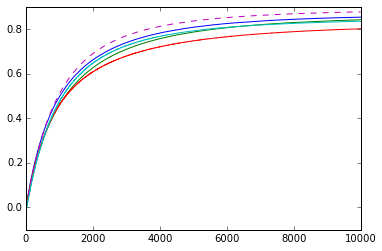

In [40]:
for s in scores[:-1]:
    plt.figure(1)
    plt.plot(range(len(s)), s)
plt.figure(1)
plt.plot(range(len(scores[-1])), scores[-1], '--')